In [1]:
import subprocess
import time
subprocess.check_output(["maturin", "develop"])

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   Compiling pyo3-build-config v0.18.3
   Compiling pyo3-ffi v0.18.3
   Compiling pyo3 v0.18.3
   Compiling numpy v0.18.0
   Compiling luthier v0.1.0 (/home/wint3rmute/code/luthier)
    Finished dev [unoptimized + debuginfo] target(s) in 9.43s
📦 Built wheel for CPython 3.10 to /tmp/.tmpSGueoY/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


b''

In [11]:
import numpy as np
import audioflux as af
from audioflux.type import SpectralFilterBankScaleType
from IPython.display import Audio, display, Image, HTML
import matplotlib.pyplot as plt
from audioflux.display import fill_spec
import PIL
from tqdm.notebook import trange, tqdm
from copy import deepcopy
from IPython.display import clear_output
import librosa
from scipy.optimize import differential_evolution
import soundfile as sf
from multiprocessing import Pool
import os
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier
from luthier.dsp import Sample
plt.rcParams['figure.dpi'] = 110
SAMPLE_RATE = 22050

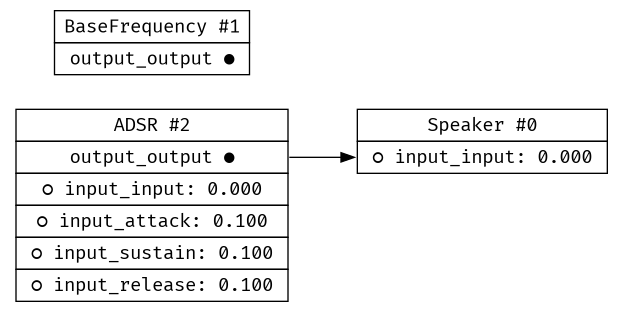

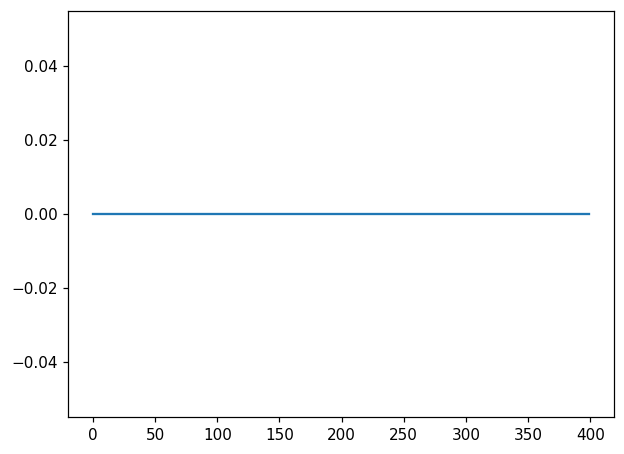

In [6]:
g = DspGraph()

sine = SineOscillator()
# sine.input_frequency = 0.440
# sine_id = g.add_sine(sine)

# g.patch( sine_id, "output_output", 1, "input_modulation" )

display(Image(g.draw()))
plt.plot(g.play(400))

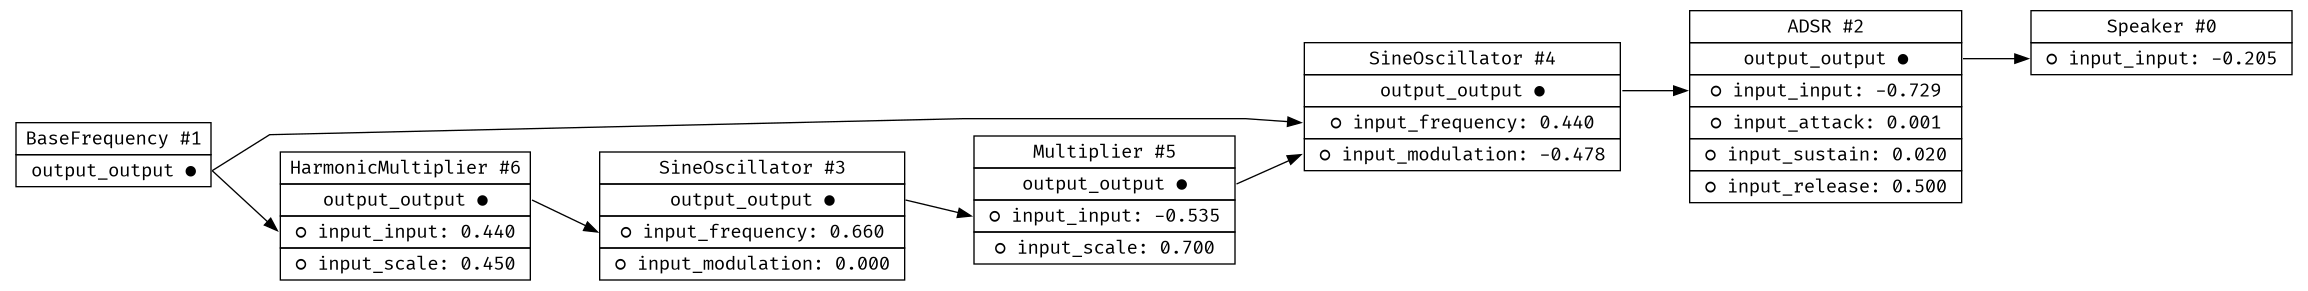

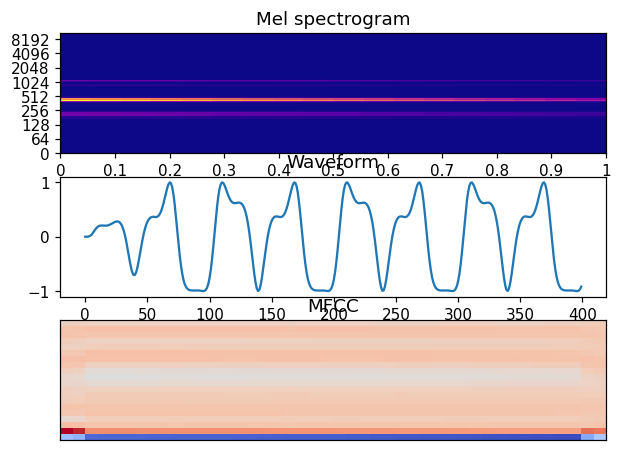

In [40]:
def one_operator_fm():
    graph = DspGraph()

    modulator = graph.add_sine(SineOscillator())
    _carrier = SineOscillator()
    # _carrier.inputs.modulation_index = 0.05
    carrier = graph.add_sine(_carrier)
    
    mod_index_scaler = graph.add_multiplier(Multiplier())
    mod_freq_mult = graph.add_harmonic_multiplier(HarmonicMultiplier())
    
    graph.set_input(mod_index_scaler, "input_scale", 0.70)
    graph.set_input(mod_freq_mult, "input_scale", 0.45)
    graph.set_input(graph.amp_adsr_node_id , "input_attack", 0.001)
    graph.set_input(graph.amp_adsr_node_id , "input_sustain", 0.02)
    graph.set_input(graph.amp_adsr_node_id , "input_release", 0.5)
    
    graph.patch(carrier, "output_output", 2, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    graph.patch(graph.base_frequency_node_id, "output_output", mod_freq_mult, "input_input" )
    graph.patch(mod_freq_mult, "output_output", modulator, "input_frequency")
    graph.patch(modulator, "output_output", mod_index_scaler, "input_input")
    graph.patch(mod_index_scaler, "output_output", carrier, "input_modulation")
    
    return graph

target_graph = one_operator_fm()

target_audio = Sample(target_graph.play(num_samples = SAMPLE_RATE * 1))
display(Image(target_graph.draw()))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
target_audio.plot_spectrogram(ax1)
target_audio.plot_waveform(ax2)
target_audio.plot_mfcc(ax3)
target_audio.show_player()